In [1]:
import anndata as ad
import networkx as nx
import scanpy as sc
import scglue
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams

In [2]:
scglue.plot.set_publication_params()
rcParams["figure.figsize"] = (4, 4)

## Loading anndatas and guidance graphs

In [3]:
rna = ad.read_h5ad("../pp_harm_data/rna-pp-harm-sub.h5ad")
adt = ad.read_h5ad("../pp_harm_data/adt-pp-harm-sub.h5ad")
cytof = ad.read_h5ad("../pp_harm_data/cytof-pp-harm-sub.h5ad")
facs = ad.read_h5ad("../pp_harm_data/facs-pp-harm-sub.h5ad")

In [4]:
rna.shape, adt.shape, cytof.shape, facs.shape

((131920, 4000), (131920, 192), (131920, 48), (131920, 12))

In [5]:
adt.var.index = adt.var.index + '_adt'
cytof.var.index = cytof.var.index + '_cytof'
facs.var.index = facs.var.index + '_facs'

## Anndatas configuration for scglue

In [6]:
scglue.models.configure_dataset(
    rna, "Normal", use_highly_variable=False,
    use_obs_names = True, use_rep="X_pca"
)

In [7]:
scglue.models.configure_dataset(
    adt, "Normal", use_highly_variable=False, 
    use_obs_names = True
)

In [8]:
scglue.models.configure_dataset(
    cytof, "Normal", use_highly_variable=False,
    use_batch='batch'
)

In [9]:
scglue.models.configure_dataset(
    facs, "Normal", use_highly_variable=False
)

## Set functions used in scglue pipeline

In [10]:
def model_fit(result_path, int_type, corr_type):
    #full integration
    if int_type == 'full_integration':
        guidance_path = "guidance_graphs/" + corr_type +'/' + "guidance.graphml.gz"
        print("using guidance graph path:", guidance_path, "\n")
        guidance = nx.read_graphml(guidance_path)
        glue = scglue.models.fit_SCGLUE(
            {"rna": rna, "adt": adt, "cytof": cytof, "facs": facs}, guidance,
            fit_kws={"directory": result_path + "glue_run_report"}, model=scglue.models.PairedSCGLUEModel,
        )
    #cite integration
    else:
        guidance_path = "guidance_graphs/" + corr_type +'/' + "guidance_cite.graphml.gz"
        print("using guidance graph path", guidance_path, "\n")
        guidance = nx.read_graphml(guidance_path)
        glue = scglue.models.fit_SCGLUE(
            {"rna": rna, "adt": adt}, guidance,
            fit_kws={"directory": result_path + "glue_run_report"}, model=scglue.models.PairedSCGLUEModel,
        )
        
    return glue, guidance

In [11]:
def glue_save_model(result_path, glue):
    glue.save(result_path + "glue.dill")

In [12]:
def plot_integration_consistency(result_path, int_type, glue, guidance):
    if int_type == 'full_integration':
        dx = scglue.models.integration_consistency(glue, {"rna": rna, "adt": adt, "cytof": cytof, "facs": facs}, guidance)
    else:
        dx = scglue.models.integration_consistency(glue, {"rna": rna, "adt": adt}, guidance)
        
    ax = sns.lineplot(x="n_meta", y="consistency", data=dx).axhline(y=0.05, c="darkred", ls="--")
    plt.show()
    fig = ax.get_figure()
    fig.savefig(result_path + "scglue_run_lineplot.png")

In [14]:
def main(int_type_list = ['full_integration', 'cite_integration'],
         corr_type_list = ['no_corr', 'rna_adt_corr', 'all_corr']):
    
    for int_type in int_type_list: #run model by type of integration
        for corr_type in corr_type_list: #run model by type of correlations
            results_path = '../results/scglue/' + int_type + '/' + corr_type + '/'
            print("using results path:", results_path)
            glue, guidance = model_fit(results_path, int_type, corr_type)
            glue_save_model(results_path, glue)
            plot_integration_consistency(results_path, int_type, glue, guidance)

## Run glue

using results path: ../results/scglue/cite_integration/no_corr/
using guidance graph path guidance_graphs/no_corr/guidance_cite.graphml.gz 

[INFO] fit_SCGLUE: Pretraining SCGLUE model...
[INFO] autodevice: Using GPU 0 as computation device.
[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] check_graph: All checks passed!
[INFO] PairedSCGLUEModel: Setting `graph_batch_size` = 1455
[INFO] PairedSCGLUEModel: Setting `max_epochs` = 48
[INFO] PairedSCGLUEModel: Setting `patience` = 4
[INFO] PairedSCGLUEModel: Setting `reduce_lr_patience` = 2
[INFO] PairedSCGLUETrainer: Using training directory: "../results/scglue/cite_integration/no_corr/glue_run_report/pretrain"
[INFO] PairedSCGLUETrainer: [Epoch 10] train={'g_nll': 0.546, 'g_kl': 0.072, 'g_elbo': 0.618, 'x_rna_nll': -1.005, 'x_rna_kl': 0.011, 'x_rna_elbo': -0.994, 'x_adt_nll': 1.601, 'x_adt_kl':

2023-01-23 09:20:14,374 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "17"...
[INFO] fit_SCGLUE: Estimating balancing weight...
[INFO] estimate_balancing_weight: Clustering cells...
[INFO] estimate_balancing_weight: Matching clusters...
[INFO] estimate_balancing_weight: Matching array shape = (24, 24)...
[INFO] estimate_balancing_weight: Estimating balancing weight...
[INFO] fit_SCGLUE: Fine-tuning SCGLUE model...
[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] check_graph: All checks passed!
[INFO] PairedSCGLUEModel: Setting `graph_batch_size` = 1455
[INFO] PairedSCGLUEModel: Setting `align_burnin` = 8
[INFO] PairedSCGLUEModel: Setting `max_epochs` = 48
[INFO] PairedSCGLUEModel: Setting `patience` = 4
[INFO] PairedSCGLUEModel: Setting `reduce_lr_patience` = 2
[INFO] PairedSCGLUETrainer: Using training directory: "../results/scglue/cite_integration/no_corr/glue_run_re

2023-01-23 09:31:31,965 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "14"...
[INFO] integration_consistency: Selecting aggregation "mean" for modality "rna"
[INFO] integration_consistency: Selecting aggregation "mean" for modality "adt"
[INFO] integration_consistency: Selecting no preprocessing for modality "rna"
[INFO] integration_consistency: Selecting no preprocessing for modality "adt"
[INFO] get_metacells: Clustering metacells...
[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 10 common metacells...
[INFO] get_metacells: Clustering metacells...
[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 19 common metacells...


/home/icb/leonardo.golinelli/.conda/envs/scglue-gpu/lib/python3.10/site-packages/scglue/data.py:625: RuntimeWarning: invalid value encountered in double_scalars
  ((X[s] * X[t]).mean() - mean[s] * mean[t]) / (std[s] * std[t])


[INFO] get_metacells: Clustering metacells...
[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 49 common metacells...


/home/icb/leonardo.golinelli/.conda/envs/scglue-gpu/lib/python3.10/site-packages/scglue/data.py:625: RuntimeWarning: invalid value encountered in double_scalars
  ((X[s] * X[t]).mean() - mean[s] * mean[t]) / (std[s] * std[t])


[INFO] get_metacells: Clustering metacells...
[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 96 common metacells...


/home/icb/leonardo.golinelli/.conda/envs/scglue-gpu/lib/python3.10/site-packages/scglue/data.py:625: RuntimeWarning: invalid value encountered in double_scalars
  ((X[s] * X[t]).mean() - mean[s] * mean[t]) / (std[s] * std[t])


[INFO] get_metacells: Clustering metacells...
[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 195 common metacells...


/home/icb/leonardo.golinelli/.conda/envs/scglue-gpu/lib/python3.10/site-packages/scglue/data.py:625: RuntimeWarning: invalid value encountered in double_scalars
  ((X[s] * X[t]).mean() - mean[s] * mean[t]) / (std[s] * std[t])


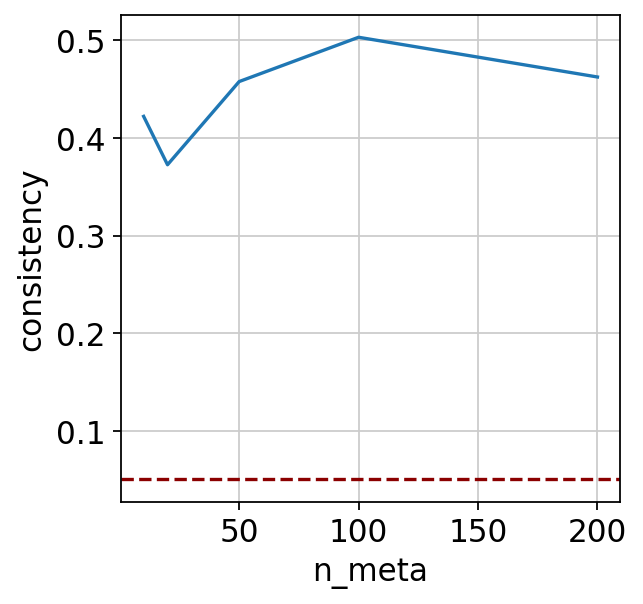

using results path: ../results/scglue/cite_integration/rna_adt_corr/
using guidance graph path guidance_graphs/rna_adt_corr/guidance_cite.graphml.gz 

[INFO] fit_SCGLUE: Pretraining SCGLUE model...
[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] check_graph: All checks passed!
[INFO] PairedSCGLUEModel: Setting `graph_batch_size` = 1446
[INFO] PairedSCGLUEModel: Setting `max_epochs` = 48
[INFO] PairedSCGLUEModel: Setting `patience` = 4
[INFO] PairedSCGLUEModel: Setting `reduce_lr_patience` = 2
[INFO] PairedSCGLUETrainer: Using training directory: "../results/scglue/cite_integration/rna_adt_corr/glue_run_report/pretrain"
[INFO] PairedSCGLUETrainer: [Epoch 10] train={'g_nll': 0.626, 'g_kl': 0.072, 'g_elbo': 0.697, 'x_rna_nll': -1.003, 'x_rna_kl': 0.012, 'x_rna_elbo': -0.991, 'x_adt_nll': 1.604, 'x_adt_kl': 0.084, 'x_adt_elbo': 1.687, 'dsc_loss'

2023-01-23 09:43:06,682 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "19"...
[INFO] fit_SCGLUE: Estimating balancing weight...
[INFO] estimate_balancing_weight: Clustering cells...
[INFO] estimate_balancing_weight: Matching clusters...
[INFO] estimate_balancing_weight: Matching array shape = (24, 22)...
[INFO] estimate_balancing_weight: Estimating balancing weight...
[INFO] fit_SCGLUE: Fine-tuning SCGLUE model...
[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] check_graph: All checks passed!
[INFO] PairedSCGLUEModel: Setting `graph_batch_size` = 1446
[INFO] PairedSCGLUEModel: Setting `align_burnin` = 8
[INFO] PairedSCGLUEModel: Setting `max_epochs` = 48
[INFO] PairedSCGLUEModel: Setting `patience` = 4
[INFO] PairedSCGLUEModel: Setting `reduce_lr_patience` = 2
[INFO] PairedSCGLUETrainer: Using training directory: "../results/scglue/cite_integration/rna_adt_corr/glue_r

2023-01-23 09:55:23,407 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "17"...
[INFO] integration_consistency: Selecting aggregation "mean" for modality "rna"
[INFO] integration_consistency: Selecting aggregation "mean" for modality "adt"
[INFO] integration_consistency: Selecting no preprocessing for modality "rna"
[INFO] integration_consistency: Selecting no preprocessing for modality "adt"
[INFO] get_metacells: Clustering metacells...
[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 10 common metacells...
[INFO] get_metacells: Clustering metacells...
[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 19 common metacells...
[INFO] get_metacells: Clustering metacells...
[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 49 common metacells...
[INFO] get_metacells: Clustering metacells...
[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 97 c

/home/icb/leonardo.golinelli/.conda/envs/scglue-gpu/lib/python3.10/site-packages/scglue/data.py:625: RuntimeWarning: invalid value encountered in double_scalars
  ((X[s] * X[t]).mean() - mean[s] * mean[t]) / (std[s] * std[t])


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 196 common metacells...


/home/icb/leonardo.golinelli/.conda/envs/scglue-gpu/lib/python3.10/site-packages/scglue/data.py:625: RuntimeWarning: invalid value encountered in double_scalars
  ((X[s] * X[t]).mean() - mean[s] * mean[t]) / (std[s] * std[t])


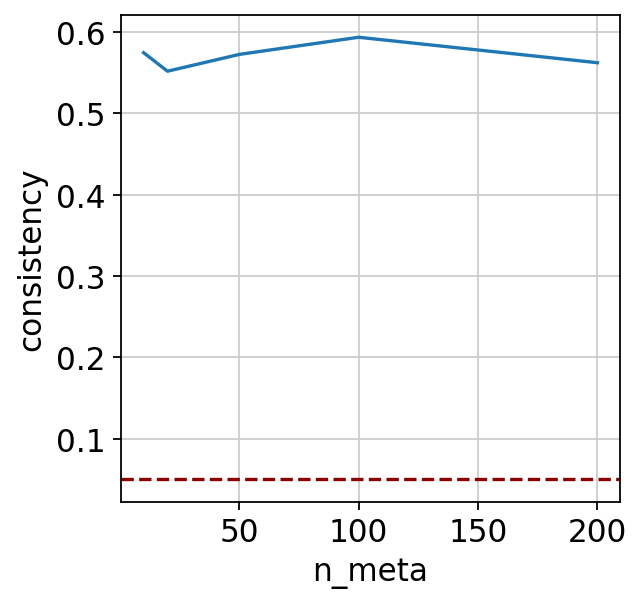

using results path: ../results/scglue/cite_integration/all_corr/
using guidance graph path guidance_graphs/all_corr/guidance_cite.graphml.gz 

[INFO] fit_SCGLUE: Pretraining SCGLUE model...
[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] check_graph: All checks passed!
[INFO] PairedSCGLUEModel: Setting `graph_batch_size` = 1446
[INFO] PairedSCGLUEModel: Setting `max_epochs` = 48
[INFO] PairedSCGLUEModel: Setting `patience` = 4
[INFO] PairedSCGLUEModel: Setting `reduce_lr_patience` = 2
[INFO] PairedSCGLUETrainer: Using training directory: "../results/scglue/cite_integration/all_corr/glue_run_report/pretrain"
[INFO] PairedSCGLUETrainer: [Epoch 10] train={'g_nll': 0.582, 'g_kl': 0.072, 'g_elbo': 0.654, 'x_rna_nll': -1.043, 'x_rna_kl': 0.011, 'x_rna_elbo': -1.032, 'x_adt_nll': 1.602, 'x_adt_kl': 0.085, 'x_adt_elbo': 1.687, 'dsc_loss': 0.612, 'va

2023-01-23 10:06:14,769 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "18"...
[INFO] fit_SCGLUE: Estimating balancing weight...
[INFO] estimate_balancing_weight: Clustering cells...
[INFO] estimate_balancing_weight: Matching clusters...
[INFO] estimate_balancing_weight: Matching array shape = (25, 21)...
[INFO] estimate_balancing_weight: Estimating balancing weight...
[INFO] fit_SCGLUE: Fine-tuning SCGLUE model...
[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] check_graph: All checks passed!
[INFO] PairedSCGLUEModel: Setting `graph_batch_size` = 1446
[INFO] PairedSCGLUEModel: Setting `align_burnin` = 8
[INFO] PairedSCGLUEModel: Setting `max_epochs` = 48
[INFO] PairedSCGLUEModel: Setting `patience` = 4
[INFO] PairedSCGLUEModel: Setting `reduce_lr_patience` = 2
[INFO] PairedSCGLUETrainer: Using training directory: "../results/scglue/cite_integration/all_corr/glue_run_r

2023-01-23 10:17:13,470 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "14"...
[INFO] integration_consistency: Selecting aggregation "mean" for modality "rna"
[INFO] integration_consistency: Selecting aggregation "mean" for modality "adt"
[INFO] integration_consistency: Selecting no preprocessing for modality "rna"
[INFO] integration_consistency: Selecting no preprocessing for modality "adt"
[INFO] get_metacells: Clustering metacells...
[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 10 common metacells...
[INFO] get_metacells: Clustering metacells...
[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 18 common metacells...


/home/icb/leonardo.golinelli/.conda/envs/scglue-gpu/lib/python3.10/site-packages/scglue/data.py:625: RuntimeWarning: invalid value encountered in double_scalars
  ((X[s] * X[t]).mean() - mean[s] * mean[t]) / (std[s] * std[t])


[INFO] get_metacells: Clustering metacells...
[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 47 common metacells...


/home/icb/leonardo.golinelli/.conda/envs/scglue-gpu/lib/python3.10/site-packages/scglue/data.py:625: RuntimeWarning: invalid value encountered in double_scalars
  ((X[s] * X[t]).mean() - mean[s] * mean[t]) / (std[s] * std[t])


[INFO] get_metacells: Clustering metacells...
[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 96 common metacells...


/home/icb/leonardo.golinelli/.conda/envs/scglue-gpu/lib/python3.10/site-packages/scglue/data.py:625: RuntimeWarning: invalid value encountered in double_scalars
  ((X[s] * X[t]).mean() - mean[s] * mean[t]) / (std[s] * std[t])


[INFO] get_metacells: Clustering metacells...
[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 195 common metacells...


/home/icb/leonardo.golinelli/.conda/envs/scglue-gpu/lib/python3.10/site-packages/scglue/data.py:625: RuntimeWarning: invalid value encountered in double_scalars
  ((X[s] * X[t]).mean() - mean[s] * mean[t]) / (std[s] * std[t])


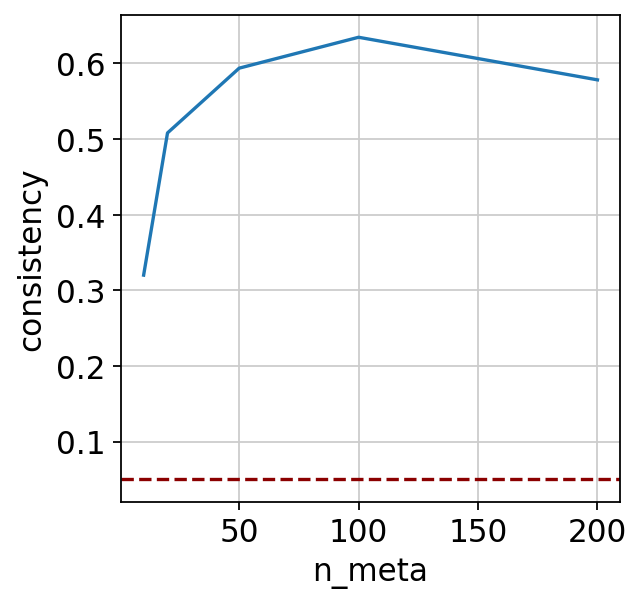

In [15]:
main(int_type_list = ['cite_integration'],
     corr_type_list = ['no_corr', 'rna_adt_corr', 'all_corr'])  #compute only cite integration across all correlation types